## Data and Package Importing

In [310]:
import sys
sys.path.append('../')
from QC_old import *
sc.settings.set_figure_params(dpi=80, frameon=False)

In [311]:
sys.executable

'/home/victoria/anaconda3/envs/LauLab/bin/python'

### Load data and preprocess

In [340]:
%time s1 = sc.read_h5ad('../data/3777-SM-2-CTTGTA_S2.h5ad') # read in one of the annotated example files

CPU times: user 3.91 s, sys: 172 ms, total: 4.08 s
Wall time: 4.07 s


In [341]:
s1 # see contents of AnnData object

AnnData object with n_obs × n_vars = 5754 × 38459 
    obs: 'ken_filter'

Standard preprocessing to get metadata for barcodes:

In [342]:
# checkpoint raw data for future filtering
s1.raw = s1

In [343]:
%%time
# quick reordering of AnnData object, since our inflection point analysis assumes that libraries are sorted from highest to lowest quality
reorder_adata(s1)

# create new "observations" as percent and mean mito genes
s1.var['mito'] = s1.var_names.str.contains('mt-') # identify mitochondrial genes
s1.obs['mean_mito'] = np.mean(s1[:,s1.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
sc.pp.calculate_qc_metrics(s1, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var

# rank cells by total counts and save as .obs
s1.obs['ranked_total_counts'] = np.argsort(s1.obs['total_counts'])

CPU times: user 1.45 s, sys: 939 ms, total: 2.38 s
Wall time: 2.76 s


### Thresholding
Let's try employing automated threshold picking from [scikit-image](https://scikit-image.org/docs/dev/api/skimage.filters.html) to determine the cutoff between our __empty__ and __non-empty__ droplets.

In [344]:
from skimage.filters import threshold_li, threshold_otsu, threshold_isodata, threshold_mean, threshold_yen, threshold_triangle # popular thresholding methods
from scipy.stats import mode

In [345]:
maxArray = np.array(s1.obs['log1p_total_counts'])

In [346]:
# use both Otsu's and Li's methods on the log-transformed total counts for each barcode:
threshOtsu = threshold_otsu(np.array(s1.obs['log1p_total_counts']))
threshLi = threshold_li(np.array(s1.obs['log1p_total_counts']))
threshIsodata = threshold_isodata(np.array(s1.obs['log1p_total_counts']))
threshMean = threshold_mean(np.array(s1.obs['log1p_total_counts']))
threshYen = threshold_yen(np.array(s1.obs['log1p_total_counts']))
threshTriangle = threshold_triangle(np.array(s1.obs['log1p_total_counts']))
globalMax = mode(maxArray)   #sorta works, returns 5.92, too low

In [347]:
globalMax

ModeResult(mode=array([5.488938], dtype=float32), count=array([34]))

Plot Otsu and Li thresholds on `log1p_total_counts`:

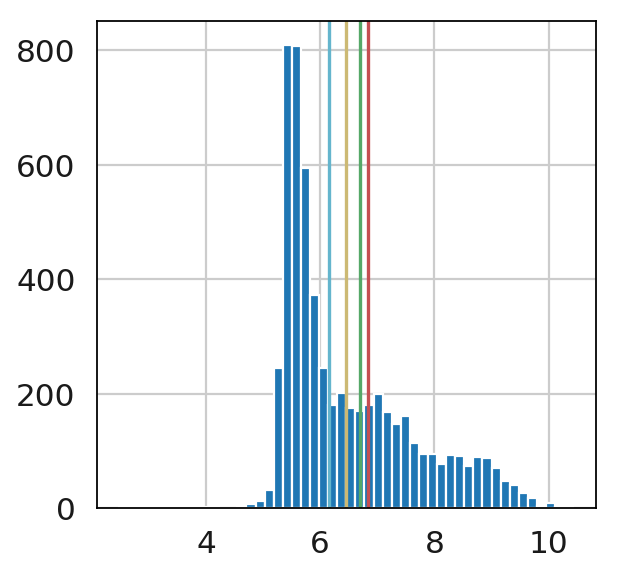

In [348]:
_ = plt.hist(s1.obs['log1p_total_counts'], bins=50)
plt.axvline(threshOtsu, color='r') # otsu threshold
plt.axvline(threshLi, color='g') # li threshold
plt.axvline(threshMean, color='y')
#plt.axvline(threshYen, color='b')
plt.axvline(threshTriangle, color='c')

### Real Max Thresholding
Threshold the entire range with threshold_mean, and then find the max peak within the range of 0 to threshold_mean

In [280]:
# get subset of array from 0 to where the threshold ends
firstArray = _[0]
secondArray = _[1]
secondArrayEnd = np.where(secondArray <= threshMean)
subFirstArray = firstArray[slice(0, np.amax(secondArrayEnd))]
subSecondArray = secondArray[slice(0, np.amax(secondArrayEnd))]

In [350]:
subSecondArray

array([2.4849067, 2.6438468, 2.8027868, 2.9617267, 3.1206667, 3.2796068,
       3.438547 , 3.5974867, 3.7564268, 3.915367 , 4.074307 , 4.233247 ,
       4.392187 , 4.551127 , 4.710067 , 4.869007 , 5.027947 , 5.186887 ,
       5.345827 , 5.504767 , 5.6637073, 5.822647 , 5.981587 , 6.1405272],
      dtype=float32)

In [281]:
# find the peak of a distribution within the range of 0 and the threshold
maxValue = max(subFirstArray)
maxIndex = np.where(subFirstArray == np.amax(subFirstArray))
realMax = subSecondArray[maxIndex]

In [282]:
_

(array([  3.,   2.,   2.,   2.,   4.,   1.,   1.,   1.,   1.,   1.,   1.,
          0.,   0.,   4.,   6.,  12.,  32., 245., 810., 807., 594., 373.,
        245., 180., 201., 174., 169., 180., 199., 168., 146., 161., 113.,
         94.,  95.,  77.,  92.,  90.,  74.,  89.,  88.,  70.,  47.,  40.,
         26.,  18.,   4.,   9.,   2.,   1.]),
 array([ 2.4849067,  2.6438468,  2.8027868,  2.9617267,  3.1206667,
         3.2796068,  3.438547 ,  3.5974867,  3.7564268,  3.915367 ,
         4.074307 ,  4.233247 ,  4.392187 ,  4.551127 ,  4.710067 ,
         4.869007 ,  5.027947 ,  5.186887 ,  5.345827 ,  5.504767 ,
         5.6637073,  5.822647 ,  5.981587 ,  6.1405272,  6.299467 ,
         6.4584074,  6.6173472,  6.776287 ,  6.9352274,  7.094167 ,
         7.253107 ,  7.4120474,  7.570987 ,  7.7299275,  7.8888674,
         8.047808 ,  8.206747 ,  8.365687 ,  8.524628 ,  8.683567 ,
         8.842507 ,  9.001448 ,  9.160387 ,  9.319327 ,  9.478268 ,
         9.637208 ,  9.796147 ,  9.955088 , 10

In [351]:
realMax[0]

5.345827

### Double Thresholding
Threshold the entire range with threshold_mean, and then threshold the range of 0 to threshold_mean with threshold_li

In [283]:
# get subset of array from 0 to where the threshold ends
firstArrayDouble = _[0]
secondArrayDouble = _[1]
secondArrayEndDouble = np.where(secondArrayDouble <= threshMean)
subFirstArrayDouble = firstArrayDouble[slice(0, np.amax(secondArrayEndDouble))]
subSecondArrayDouble = secondArrayDouble[slice(0, np.amax(secondArrayEndDouble))]

In [284]:
# threshold using thresh_li within the range of 0 and the threshold
dtMeanLi = threshold_li(subSecondArrayDouble)
dtMeanMean = threshold_mean(subSecondArrayDouble)

In [285]:
def thresholdSelection():
    mid = (secondArray[0] + secondArray[-1]) / 2
    if (realMax[0] >= (mid * 0.8)):
        return dtMeanMean
    else:
        return realMax[0]

In [286]:
thresholdSelection()

4.312717

### Find inflection point

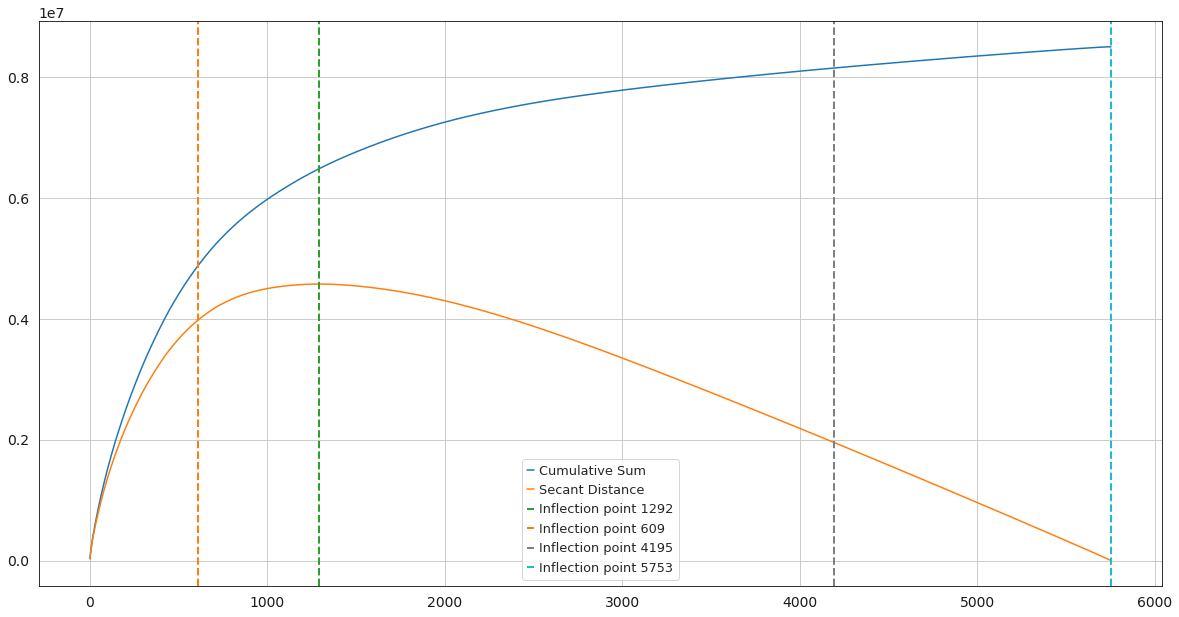

Inflection point at index
3839    1292
4089     609
1817    4195
0       5753
Name: total_counts, dtype: int64 for [0, 31, 70, 100] percentiles of greatest secant distances


{0: 1292, 31: 609, 70: 4195, 100: 5753}

In [287]:
# inflection_percentiles are percentages of maximum secant distance. we wanna pick one to the right of the maximum
find_inflection(s1, inflection_percentiles = [0,31,70,100], output_prefix='')

The purple cutoff looks pretty good if we were manually filtering the data. Let's see how many total counts and log1p-transformed total counts the cell at that position has:

In [288]:
s1.obs['total_counts'][3401] # see the total counts for the cutoff point

319.0

In [289]:
s1.obs['log1p_total_counts'][3401] # see the log-transformed total counts for the cutoff point; this should be close to otsu or li threshold

5.768321

So the above number should correspond to a cutoff between the two 'lumps' in our `log1p_total_counts` distribution, and it looks close to our `Otsu` and `Li` thresholds.  
Let's plot it to compare to the automated thresholds from `skimage`:

In [290]:
# find min counts of cells ken_filter marked as 1
log1pTotalCountsFilter = np.where(s1.obs["ken_filter"] == 1)[0]
subsetLog1pTotalCounts = s1.obs.iloc[log1pTotalCountsFilter]["log1p_total_counts"]
minCellCounts = np.percentile(subsetLog1pTotalCounts, q = 0)

In [291]:
minCellCounts

3.25809645652771

In [292]:
#log1pTotalCountsFilterEmpty = np.where(s1.obs["empty"] == 1)[0]
#subsetLog1pTotalCountsEmpty = s1.obs.iloc[log1pTotalCountsFilterEmpty]["log1p_total_counts"]
#minCellCountsEmpty = np.percentile(subsetLog1pTotalCountsEmpty, q = 100)

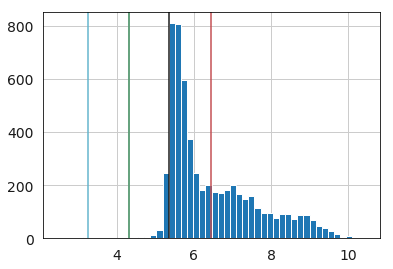

In [293]:
_ = plt.hist(s1.obs['log1p_total_counts'], bins=50)
#plt.axvline(threshOtsu, color='r') # otsu
#plt.axvline(threshLi, color='g') # li
plt.axvline(threshMean, color='r') # red
#plt.axvline(threshYen, color='b')
#plt.axvline(threshTriangle, color='m')
plt.axvline(realMax[0], color='k') # black
plt.axvline(minCellCounts, color='c') # cyan
#plt.axvline(dtMeanLi, color = 'g') # green
plt.axvline(dtMeanMean, color = 'm') # magenta
plt.axvline(thresholdSelection(), color = 'g')
#plt.axvline(s1.obs['log1p_total_counts'][3401], color='y') # threshold chosen from one of the inflection point percentage cutoffs

In [294]:
np.expm1(realMax[0])

208.73128

In [218]:
np.expm1(dtMeanLi)

568.56177

In [219]:
np.expm1(dtMeanMean)

702.9658

In [220]:
#s1.obs.index

In [221]:
expmRealMax = np.expm1(realMax[0])
expmThreshMean = np.expm1(threshMean)
expmDtMeanMean = np.expm1(dtMeanMean)
expmDtMeanLi = np.expm1(dtMeanLi)

In [222]:
emptyDropsThresh = pd.read_csv("emptyDrops-thresh-2771-S3.csv")

In [223]:
# only use when barcode data type does not match with index data type
emptyDropsThresh.barcode = emptyDropsThresh.barcode.astype(str)

In [224]:
s1.obs = s1.obs.merge(emptyDropsThresh, left_on = 'index', right_on = 'barcode')

ValueError: Length does not match.

In [ ]:
s1.obs.loc[s1.obs["total_counts"] <= expmRealMax, "real_max_filter"] = 0
s1.obs.loc[s1.obs["total_counts"] > expmRealMax, "real_max_filter"] = 1
realMaxIndex = np.where(s1.obs["real_max_filter"] == 0)[0]

In [ ]:
s1.obs.loc[s1.obs["total_counts"] <= expmDtMeanLi, "double_thresh_mean_li"] = 0
s1.obs.loc[s1.obs["total_counts"] > expmDtMeanLi, "double_thresh_mean_li"] = 1
dtMeanLiIndex = np.where(s1.obs["double_thresh_mean_li"] == 0)[0]

In [ ]:
s1.obs.loc[s1.obs["total_counts"] <= expmDtMeanMean, "double_thresh_mean_mean"] = 0
s1.obs.loc[s1.obs["total_counts"] > expmDtMeanMean, "double_thresh_mean_mean"] = 1
dtMeanMeanIndex = np.where(s1.obs["double_thresh_mean_mean"] == 0)[0]

In [ ]:
s1.obs.loc[s1.obs["total_counts"] <= expmThreshMean, "thresh_mean_filter"] = 0
s1.obs.loc[s1.obs["total_counts"] > expmThreshMean, "thresh_mean_filter"] = 1
threshMeanIndex = np.where(s1.obs["thresh_mean_filter"] == 0)[0]

In [ ]:
kenIndex = np.where(s1.obs["ken_filter"] == 0)[0]
emptyDropsIndex = np.where(s1.obs["empty"] == 1)[0]

In [ ]:
# get the total number of cells that are not empty
numCellsRealMax = s1.obs["barcode"].count() - s1.obs["real_max_filter"].sum()
numCellsDtMeanLi = s1.obs["barcode"].count() - s1.obs["double_thresh_mean_li"].sum()
numCellsDtMeanMean = s1.obs["barcode"].count() - s1.obs["double_thresh_mean_mean"].sum()
numCellsEmptyDrops = s1.obs["empty"].sum()

In [ ]:
print("number of cells real max: ", numCellsRealMax)
print("number of cells double thresh mean li: ", numCellsDtMeanLi)
print("number of cells double thresh mean mean: ", numCellsDtMeanMean)
print("number of cells emptyDrops: ", numCellsEmptyDrops)

### Percent Real Max Thresholding

In [109]:
numCellsRealMax30 = int(np.round(numCellsRealMax * 0.3))
numCellsRealMax50 = int(np.round(numCellsRealMax * 0.5))
numCellsRealMax70 = int(np.round(numCellsRealMax * 0.7))
numCellsRealMax80 = int(np.round(numCellsRealMax * 0.8))
numCellsRealMax90 = int(np.round(numCellsRealMax * 0.9))

In [110]:
realMax30 = s1.obs.iloc[-numCellsRealMax30,]["log1p_total_counts"]
realMax50 = s1.obs.iloc[-numCellsRealMax50,]["log1p_total_counts"]
realMax70 = s1.obs.iloc[-numCellsRealMax70,]["log1p_total_counts"]
realMax80 = s1.obs.iloc[-numCellsRealMax80,]["log1p_total_counts"]
realMax90 = s1.obs.iloc[-numCellsRealMax90,]["log1p_total_counts"]

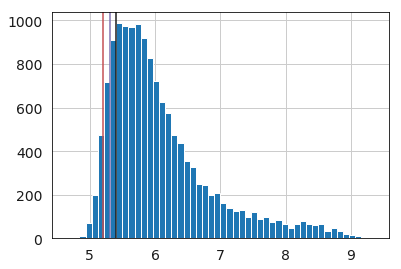

In [111]:
_ = plt.hist(s1.obs['log1p_total_counts'], bins=50)
plt.axvline(realMax[0], color = 'k')
plt.axvline(dtMeanMean, color = 'm')
#plt.axvline(realMax90, color='r')
#plt.axvline(realMax80, color='g')
#plt.axvline(realMax70, color='m')
plt.axvline(realMax30, color = 'r')

In [112]:
np.expm1(realMax70)

204.99998

In [113]:
s1.obs

,ken_filter,mean_mito,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,...,LogProb,PValue,Limited,FDR,empty,barcode,real_max_filter,double_thresh_mean_li,double_thresh_mean_mean,thresh_mean_filter
0,1,25.054054,3549,8.174703,11439.0,9.344872,23.612204,31.340152,40.711601,56.324854,...,-17611.166666,0.0001,True,0.0,0,bcGJGH,1.0,1.0,1.0,1.0
1,1,28.162163,3786,8.239329,10901.0,9.296701,23.649206,30.611870,39.271626,54.031740,...,-18395.172730,0.0001,True,0.0,0,bcHHFW,1.0,1.0,1.0,1.0
2,1,36.243244,3101,8.039802,10441.0,9.253592,29.154296,36.366248,45.618236,61.066948,...,-15387.323197,0.0001,True,0.0,0,bcHMGZ,1.0,1.0,1.0,1.0
3,1,71.432434,3451,8.146709,10237.0,9.233862,35.957800,40.890886,47.592068,59.831982,...,-16400.994929,0.0001,True,0.0,0,bcFQMC,1.0,1.0,1.0,1.0
4,1,12.864865,1682,7.428333,9881.0,9.198470,67.857504,72.168809,77.279628,85.801032,...,-9434.997566,0.0001,True,0.0,0,bcEFAX,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14184,0,2.486486,46,3.850148,133.0,4.897840,100.000000,100.000000,100.000000,100.000000,...,NaN,NaN,NaN,NaN,1,bcEGMG,0.0,0.0,0.0,0.0
14185,0,2.513514,46,3.850148,132.0,4.890349,100.000000,100.000000,100.000000,100.000000,...,NaN,NaN,NaN,NaN,1,bcEKGU,0.0,0.0,0.0,0.0
14186,0,1.594595,75,4.330733,130.0,4.875197,80.769231,100.000000,100.000000,100.000000,...,NaN,NaN,NaN,NaN,1,bcDARH,0.0,0.0,0.0,0.0
14187,0,2.081081,51,3.951244,117.0,4.770685,99.145299,100.000000,100.000000,100.000000,...,NaN,NaN,NaN,NaN,1,bcHPUJ,0.0,0.0,0.0,0.0


In [48]:
# A vs. B is equal to the elements present in A but not in B
# B vs. A is equal to the elements present in B but not in A

In [49]:
emptyDropsKenSet = len(set(emptyDropsIndex).difference(set(kenIndex))) # where emptyDrops_index is larger than ken_index

realMaxKenSet = len(set(realMaxIndex).difference(set(kenIndex))) # where real_max_index is larger than ken_index
realMaxEmptyDropsSet = len(set(realMaxIndex).difference(set(emptyDropsIndex))) # where real_max_index is larger than emptyDrops_index

dtMeanLiKenSet = len(set(dtMeanLiIndex).difference(set(kenIndex)))
dtMeanLiEmptyDropsSet = len(set(dtMeanLiIndex).difference(set(emptyDropsIndex)))

dtMeanMeanKenSet = len(set(dtMeanMeanIndex).difference(set(kenIndex)))
dtMeanMeanEmptyDropsSet = len(set(dtMeanMeanIndex).difference(set(emptyDropsIndex)))

threshMeanKenSet = len(set(threshMeanIndex).difference(set(kenIndex)))
threshMeanEmptyDropsSet = len(set(threshMeanIndex).difference(set(emptyDropsIndex)))

In [50]:
kenEmptyDropsSet = len(set(kenIndex).difference(set(emptyDropsIndex))) # where ken_index is larger than emptyDrops_index

kenRealMaxSet = len(set(kenIndex).difference(set(realMaxIndex))) # where ken_index is larger than real_max
emptyDropsRealMaxSet = len(set(emptyDropsIndex).difference(set(realMaxIndex))) # where emptyDrops_index is larger than real_max_index

kenDtMeanLiSet = len(set(kenIndex).difference(set(dtMeanLiIndex)))
emptyDropsDtMeanLiSet = len(set(emptyDropsIndex).difference(set(dtMeanLiIndex)))

kenDtMeanMeanSet = len(set(kenIndex).difference(set(dtMeanMeanIndex)))
emptyDropsDtMeanMeanSet = len(set(emptyDropsIndex).difference(set(dtMeanMeanIndex)))

kenThreshMeanSet = len(set(kenIndex).difference(set(threshMeanIndex)))
emptyDropsThreshMeanSet = len(set(emptyDropsIndex).difference(set(threshMeanIndex)))

In [51]:
# overlap for empty cells
print("emptyDrops vs. ken: ", emptyDropsKenSet)

print("real max vs. ken: ", realMaxKenSet)
print("real max vs. emptyDrops: ", realMaxEmptyDropsSet)

print("double thresh mean li vs. ken: ", dtMeanLiKenSet)
print("double thresh mean li vs. emptyDrops: ", dtMeanMeanEmptyDropsSet)

print("double thresh mean mean vs. ken: ", dtMeanMeanKenSet)
print("double thresh mean mean vs. emptyDrops: ", dtMeanMeanEmptyDropsSet)

print("thresh mean vs. ken: ", threshMeanKenSet)
print("thresh mean vs. emptyDrops: ", threshMeanEmptyDropsSet)

emptyDrops vs. ken:  1
real max vs. ken:  8
real max vs. emptyDrops:  2462
double thresh mean li vs. ken:  0
double thresh mean li vs. emptyDrops:  428
double thresh mean mean vs. ken:  0
double thresh mean mean vs. emptyDrops:  428
thresh mean vs. ken:  13
thresh mean vs. emptyDrops:  3214


In [52]:
print("ken vs. emptyDrops: ", kenEmptyDropsSet)

print("ken vs. real max: ", kenRealMaxSet)
print("emptyDrops vs. real max: ", emptyDropsRealMaxSet)

print("ken vs. double thresh mean li: ", kenDtMeanLiSet)
print("emptyDrops vs. double thresh mean li: ", emptyDropsDtMeanLiSet)

print("ken vs. double thresh mean mean: ", kenDtMeanMeanSet)
print("emptyDrops vs. double thresh mean mean: ", emptyDropsDtMeanMeanSet)

print("ken vs. thresh mean: ", kenThreshMeanSet)
print("emptyDrops vs. thresh mean: ", emptyDropsThreshMeanSet)

ken vs. emptyDrops:  5739
ken vs. real max:  3284
emptyDrops vs. real max:  0
ken vs. double thresh mean li:  6746
emptyDrops vs. double thresh mean li:  1242
ken vs. double thresh mean mean:  6417
emptyDrops vs. double thresh mean mean:  1107
ken vs. thresh mean:  2537
emptyDrops vs. thresh mean:  0


In [53]:
# Histograms after filtering

In [457]:
s1.obs.index = s1.obs.barcode

In [458]:
s2 = s1.obs.copy()

In [459]:
def emptyLog1pTotalCounts(dataframe, filterMethod, whichColor):
    if (filterMethod == "empty"):
        whichEmpty = 0
    else:
        whichEmpty = 1
    log1pTotalCountsFilter = np.where(dataframe[filterMethod] == whichEmpty)[0]
    subsetLog1pTotalCounts = dataframe.iloc[log1pTotalCountsFilter]["log1p_total_counts"]
    
    _ = plt.hist(subsetLog1pTotalCounts, bins = 50, color = whichColor)
    plt.axvline(realMax[0], color = 'k')
    return (log1pTotalCountsFilter, dataframe[filterMethod] == whichEmpty)

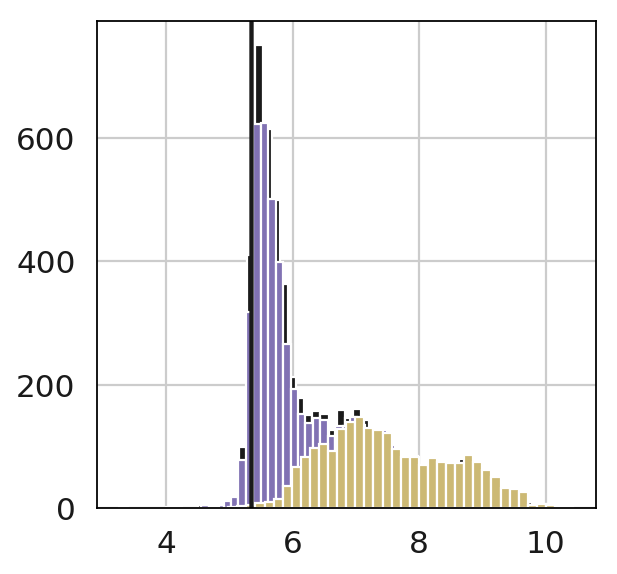

In [460]:
realMaxDataset, realMaxBoolVector = emptyLog1pTotalCounts(s2, "real_max_filter", 'g')
dtMeanLiDataset, dtMeanLiBoolVector = emptyLog1pTotalCounts(s2, "double_thresh_mean_li", 'k')
dtMeanMeanDataset, dtMeanMeanBoolVector = emptyLog1pTotalCounts(s2, "double_thresh_mean_mean", 'm')
emptyDropsDataset, emptyDropsBoolVector = emptyLog1pTotalCounts(s2, "empty", 'r')
threshMeanDataset, threshMeanBoolVector = emptyLog1pTotalCounts(s2, "thresh_mean_filter", 'b')
kenFilterDataset, kenFilterBoolVector = emptyLog1pTotalCounts(s2, "ken_filter", 'y')

In [461]:
s1.write_h5ad("filtered-3777-S2.h5ad", compression = "gzip")

... storing 'Limited' as categorical


In [462]:
#s3 = s1[realMaxDataset].copy()

In [318]:
#s3.write_h5ad("realMaxDataset-2771-S3.h5ad", compression = "gzip")